## 1. Pendahuluan: Konsep RNN dan LSTM

### Recurrent Neural Network (RNN)

Recurrent Neural Network (RNN) adalah jenis jaringan saraf yang memiliki koneksi berulang, memungkinkan informasi sebelumnya disimpan dan digunakan untuk memprediksi output di masa depan. RNN sangat cocok untuk data sekuensial seperti time series karena:

1. **Memori Internal**: RNN memiliki "memori" internal yang bisa menyimpan informasi tentang input sebelumnya.
2. **Koneksi Berulang**: Memiliki koneksi yang berulang memungkinkan jaringan untuk mengingat konteks historis.
3. **Berbagi Parameter**: Parameter yang sama digunakan pada setiap langkah waktu, membuatnya efisien untuk data berurutan.

Namun, RNN sederhana memiliki kelemahan yaitu masalah "vanishing gradient" saat menangani sekuens panjang, di mana RNN sulit mengingat informasi dari langkah-langkah jauh sebelumnya.

### Long Short-Term Memory (LSTM)

LSTM adalah variasi khusus dari RNN yang dirancang untuk mengatasi masalah vanishing gradient dan efektif menangani dependensi jangka panjang. LSTM memiliki karakteristik:

1. **Cell State**: Jalur yang memungkinkan informasi mengalir dengan perubahan minimal.
2. **Mekanisme Gerbang (Gates)**: Memiliki tiga gerbang:
   - **Forget Gate**: Menentukan informasi mana yang dibuang dari cell state.
   - **Input Gate**: Menentukan nilai baru mana yang akan disimpan.
   - **Output Gate**: Menentukan output berdasarkan cell state dan input saat ini.

LSTM sangat efektif untuk prediksi data time series finansial karena kemampuannya untuk:
- Menangkap pola jangka panjang
- Mengingat informasi penting dari masa lalu
- Mengabaikan noise dalam data

## 2. Import Library yang Diperlukan




In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Library untuk preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Library untuk deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Konfigurasi tampilan grafik
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# Mengabaikan warning
import warnings
warnings.filterwarnings('ignore')

# Menetapkan seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)



## 3. Membaca dan Eksplorasi Data




In [91]:
# Membaca data
train_data = pd.read_csv(r"C:\Users\BRAVO\Machine Learning\Tugas RNN & LTSM\FB_training.csv") 
test_data = pd.read_csv(r"C:\Users\BRAVO\Machine Learning\Tugas RNN & LTSM\FB_test.csv")

# Menampilkan informasi data training
print("Training Data Info:")
print(f"Shape: {train_data.shape}")
train_data.head()


Training Data Info:
Shape: (1789, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,5/18/2012,42.05,45.00,38.00,38.23,38.23,"573,576,400"
1,5/21/2012,36.53,36.66,33.00,34.03,34.03,"168,192,700"
2,5/22/2012,32.61,33.59,30.94,31.00,31.00,"101,786,600"
3,5/23/2012,31.37,32.50,31.36,32.00,32.00,"73,600,000"
4,5/24/2012,32.95,33.21,31.77,33.03,33.03,"50,237,200"


In [92]:
# Menampilkan informasi data testing
print("Testing Data Info:")
print(f"Shape: {test_data.shape}")
test_data.head()


Testing Data Info:
Shape: (22, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,7/1/2019,195.21,195.28,191.93,193.00,193.00,"14,204,700"
1,7/2/2019,193.00,195.00,192.71,195.00,195.00,"9,050,000"
2,7/3/2019,194.16,197.40,194.16,197.20,197.20,"10,246,100"
3,7/5/2019,196.18,197.07,194.17,196.40,196.40,"11,164,100"
4,7/8/2019,195.19,196.68,193.64,195.76,195.76,"9,723,900"


In [ ]:
# Load data training dan test dari path lokal
train_data = pd.read_csv(r"C:\Users\BRAVO\Machine Learning\Tugas RNN & LTSM\FB_training.csv")
test_data = pd.read_csv(r"C:\Users\BRAVO\Machine Learning\Tugas RNN & LTSM\FB_test.csv")

# Bersihkan nama kolom
train_data.columns = train_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

# Ubah kolom 'Date' ke datetime dan set sebagai index
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Bersihkan nilai koma dari kolom 'Volume'
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(int)
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(int)

# Tampilkan hasil
print(train_data.head())


             Open   High    Low  Close  Adj Close     Volume
Date                                                        
2012-05-18  42.05  45.00  38.00  38.23      38.23  573576400
2012-05-21  36.53  36.66  33.00  34.03      34.03  168192700
2012-05-22  32.61  33.59  30.94  31.00      31.00  101786600
2012-05-23  31.37  32.50  31.36  32.00      32.00   73600000
2012-05-24  32.95  33.21  31.77  33.03      33.03   50237200


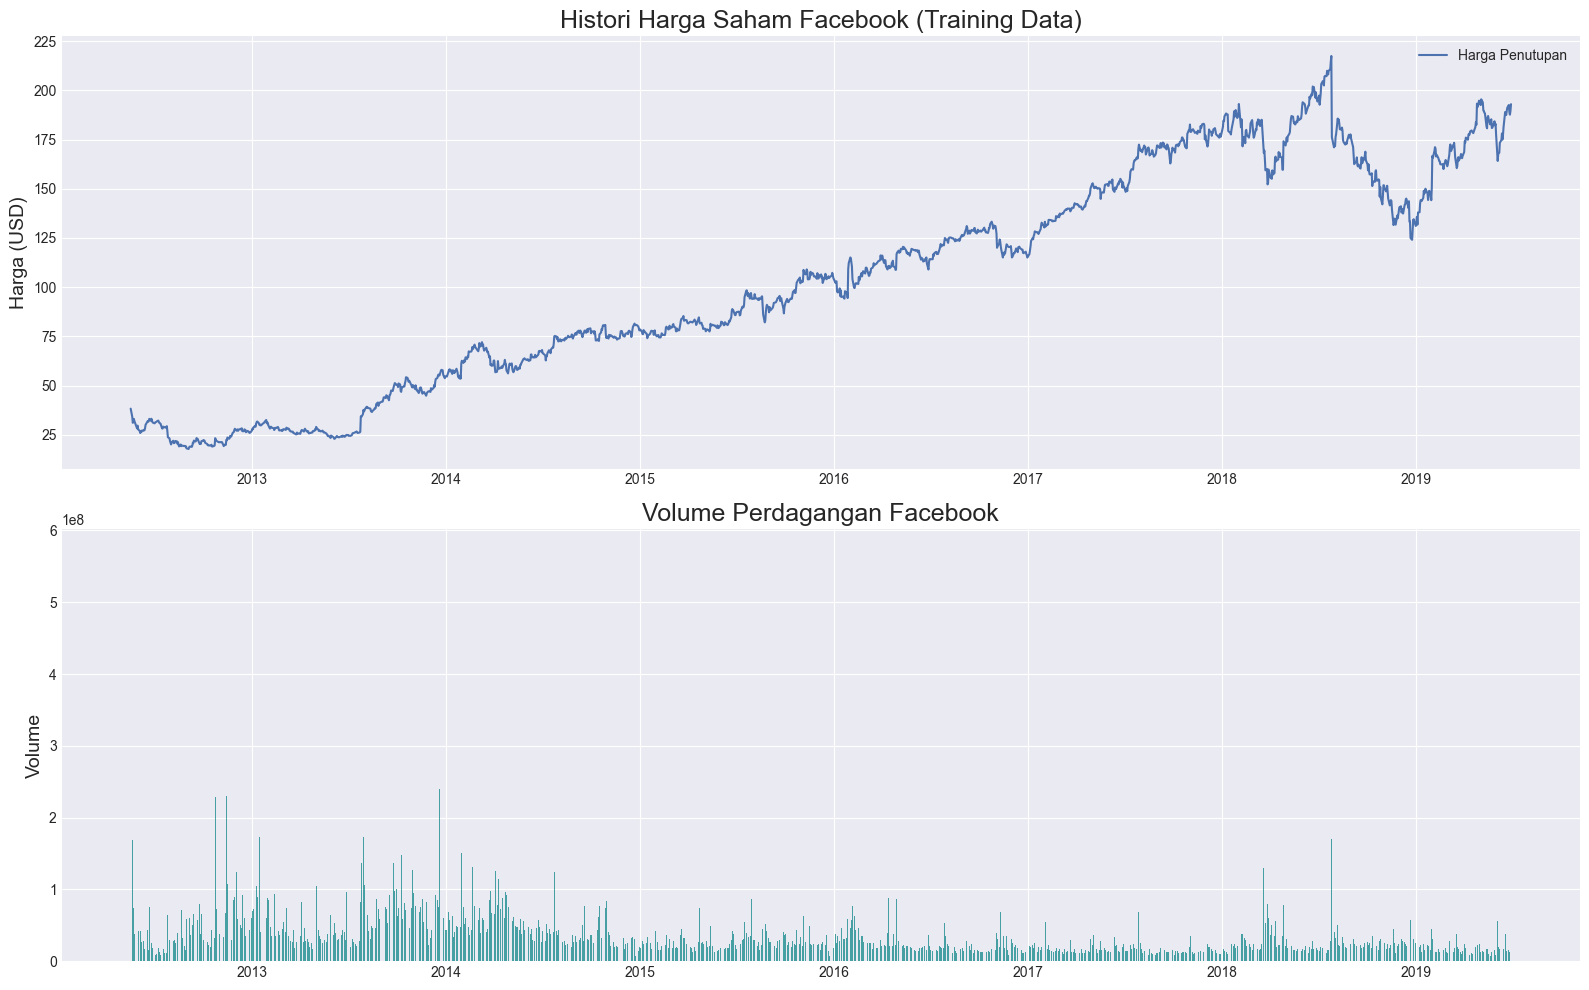

In [105]:
# Visualisasi data historis harga saham Facebook
plt.figure(figsize=(16, 10))

# Plot harga Close
plt.subplot(2, 1, 1)
plt.plot(train_data.index, train_data['Close'], label='Harga Penutupan')
plt.title('Histori Harga Saham Facebook (Training Data)')
plt.ylabel('Harga (USD)')
plt.legend()
plt.grid(True)

# Plot volume
plt.subplot(2, 1, 2)
plt.bar(train_data.index, train_data['Volume'], color='teal', alpha=0.7)
plt.title('Volume Perdagangan Facebook')
plt.ylabel('Volume')
plt.grid(True)

plt.tight_layout()
plt.show()


In [106]:
# Analisis Statistik Deskriptif
print("Statistik Deskriptif Training Data:")
train_data.describe()


Statistik Deskriptif Training Data:


,Open,High,Low,Close,Adj Close,Volume
count,1789.000000,1789.000000,1789.000000,1789.000000,1789.000000,1.789000e+03
mean,103.677580,104.793577,102.523281,103.699871,103.699871,3.480953e+07
std,54.200281,54.644551,53.775570,54.256291,54.256291,3.048872e+07
min,18.080000,18.270000,17.550000,17.730000,17.730000,5.913100e+06
25%,59.670000,60.580000,58.490000,59.720000,59.720000,1.747020e+07
50%,103.740000,104.720000,102.060000,103.940000,103.940000,2.526000e+07
75%,151.850000,153.470000,150.300000,151.800000,151.800000,4.245300e+07
max,215.720000,218.620000,214.270000,217.500000,217.500000,5.735764e+08


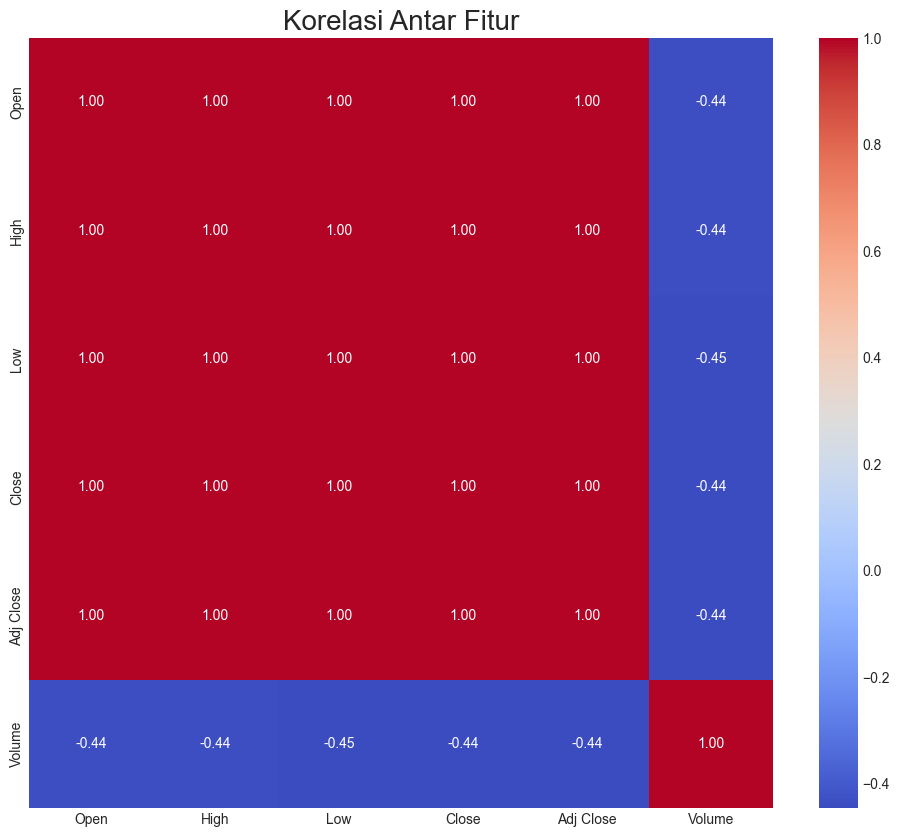

In [107]:
# Melihat korelasi antara fitur
plt.figure(figsize=(12, 10))
correlation = train_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi Antar Fitur', fontsize=20)
plt.show()



## 4. Preprocessing Data



In [108]:
# Untuk prediksi, kita akan fokus pada kolom 'Close'
data = train_data['Close'].values.reshape(-1, 1)

# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Fungsi untuk membuat dataset X dan y
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Menentukan time step (jumlah hari untuk memprediksi 1 hari berikutnya)
time_step = 60

# Membuat dataset training
X_train, y_train = create_dataset(scaled_data, time_step)

# Reshape input untuk kebutuhan RNN dan LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train.shape}")


Shape X_train: (1729, 60, 1)
Shape y_train: (1729,)


In [109]:
# Mempersiapkan data testing
test_complete = pd.concat([train_data['Close'][-time_step:], test_data['Close']])
test_complete = test_complete.values.reshape(-1, 1)
test_scaled = scaler.transform(test_complete)

# Membuat dataset testing
X_test, y_test = [], []
for i in range(time_step, len(test_complete)):
    X_test.append(test_scaled[i-time_step:i, 0])
    y_test.append(test_scaled[i, 0])

X_test, y_test = np.array(X_test), np.array(y_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")


Shape X_test: (22, 60, 1)
Shape y_test: (22,)



## 5. Implementasi Model RNN



In [110]:
# Membuat model SimpleRNN
def create_rnn_model():
    model = Sequential()
    
    # Lapisan SimpleRNN pertama dengan return_sequences=True untuk menumpuk lapisan RNN
    model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    
    # Lapisan SimpleRNN kedua
    model.add(SimpleRNN(units=50))
    model.add(Dropout(0.2))
    
    # Lapisan output
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Inisialisasi dan training model RNN
rnn_model = create_rnn_model()
print(rnn_model.summary())

# Callbacks untuk early stopping dan model checkpoint
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
mc = ModelCheckpoint('best_rnn_model.h5', monitor='val_loss', save_best_only=True)

# Training model RNN
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es, mc],
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,701 (30.08 KB)

 Trainable params: 7,701 (30.08 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1465

49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.1399 - val_loss: 0.0310
Epoch 2/100
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0277

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0276 - val_loss: 0.0019
Epoch 3/100
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0151

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0150 - val_loss: 0.0015
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0141 - val_loss: 0.0017
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 6/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0088

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0088 - val_loss: 0.0012
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0070

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 8/100
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0071

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0057 - val_loss: 0.0013
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0053 - val_loss: 0.0012
Epoch 12/100
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0054 - val_loss: 8.1551e-04
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 9.1755e-04
Epoch 14/100
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0042

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0042 - val_loss: 7.4229e-04
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0036 - val_loss: 7.4606e-04
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0038 - val_loss: 6.8895e-04
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0031 - val_loss: 7.2533e-04
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 19/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0030 - val_loss: 7.7535e-04
Epoch 20/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 21/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 8.5361e-04
Epoch 22/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 23/100
45/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0030 - val_loss: 6.1369e-04
Epoch 24/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0027 - val_loss: 5.6559e-04
Epoch 25/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 7.4174e-04
Epoch 26/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 8.2685e-04
Epoch 27/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 28/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0025 - val_loss: 5.6775e-04
Epoch 29/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 30/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 6.2462e-04
Epoch 31/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 32/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 5.7193e-04
Epoch 33/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0021

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 5.1985e-04
Epoch 34/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - val_loss: 8.4715e-04
Epoch 35/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 7.3144e-04
Epoch 36/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0020 - val_loss: 8.8588e-04
Epoch 37/100
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 4.7885e-04
Epoch 38/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 6.8024e-04
Epoch 39/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 5.4890e-04
Epoch 40/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0018 - val_loss: 6.4621e-04
Epoch 41/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 6.6210e-04
Epoch 42/100
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0018

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0018 - val_loss: 4.7623e-04
Epoch 43/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 4.8173e-04
Epoch 44/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 4.8004e-04
Epoch 45/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 7.0471e-04
Epoch 46/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 7.8333e-04
Epoch 47/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0017 - val_loss: 5.8305e-04
Epoch 48/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 5.3218e-04
Epoch 49/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 50/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0015 - val_loss: 4.6067e-04
Epoch 51/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 5.3119e-04
Epoch 52/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 53/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0015 - val_loss: 4.7293e-04
Epoch 54/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 5.7444e-04
Epoch 55/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0016 - val_loss: 4.9648e-04
Epoch 56/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 4.6367e-04
Epoch 57/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 58/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0014 - val_loss: 6.1036e-04
Epoch 59/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 60/100
46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0013 - val_loss: 4.1671e-04
Epoch 61/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0013 - val_loss: 4.3693e-04
Epoch 62/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0012

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 4.1617e-04
Epoch 63/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 4.4883e-04
Epoch 64/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 4.3641e-04
Epoch 65/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0013 - val_loss: 5.6505e-04
Epoch 66/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 4.2166e-04
Epoch 67/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 6.7873e-04
Epoch 68/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 4.7360e-04
Epoch 69/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 8.3975e-04 - val_loss: 6.8590e-04
Epoch 70/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 5.3888e-04
Epoch 71/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 72/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0010 - val_loss: 7.1337e-04


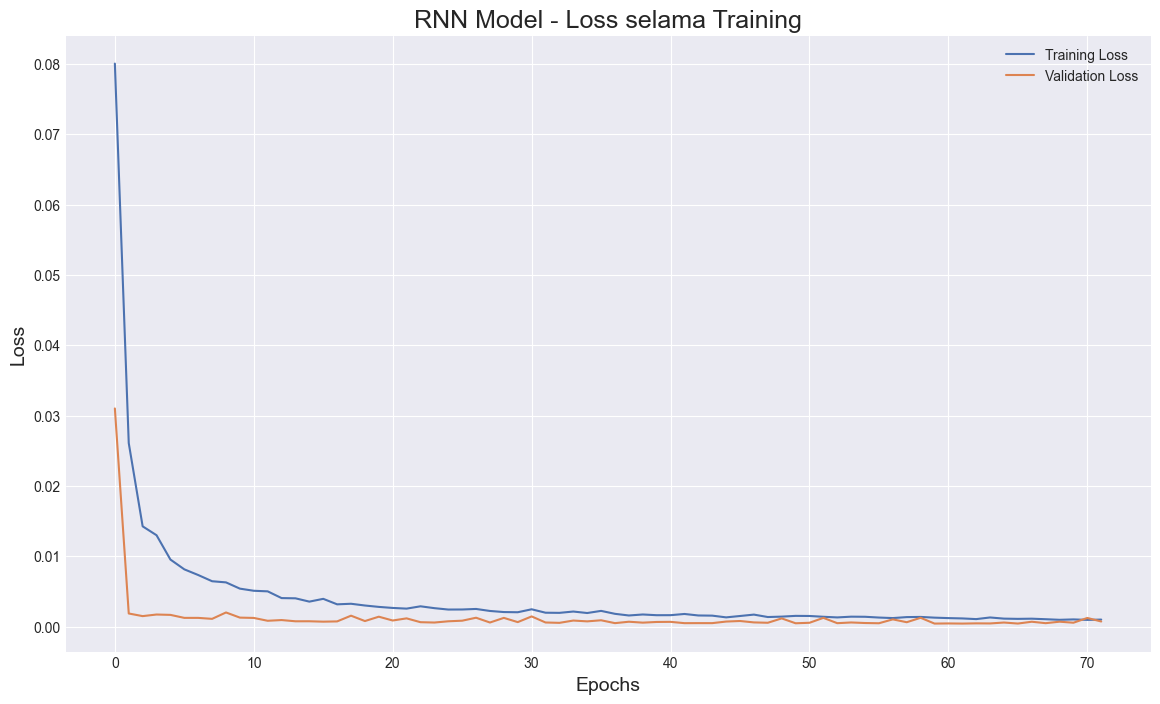

In [111]:
# Visualisasi hasil training model RNN
plt.figure(figsize=(14, 8))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Model - Loss selama Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [112]:
# Prediksi menggunakan model RNN
rnn_predictions = rnn_model.predict(X_test)

# Inverse transform untuk mendapatkan nilai asli
rnn_predictions = scaler.inverse_transform(rnn_predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluasi kinerja model RNN
rnn_mse = mean_squared_error(y_test_actual, rnn_predictions)
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(y_test_actual, rnn_predictions)
rnn_r2 = r2_score(y_test_actual, rnn_predictions)

print(f"RNN Model - Mean Squared Error: {rnn_mse:.4f}")
print(f"RNN Model - Root Mean Squared Error: {rnn_rmse:.4f}")
print(f"RNN Model - Mean Absolute Error: {rnn_mae:.4f}")
print(f"RNN Model - R-squared: {rnn_r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
RNN Model - Mean Squared Error: 9.2071
RNN Model - Root Mean Squared Error: 3.0343
RNN Model - Mean Absolute Error: 2.5714
RNN Model - R-squared: 0.2521


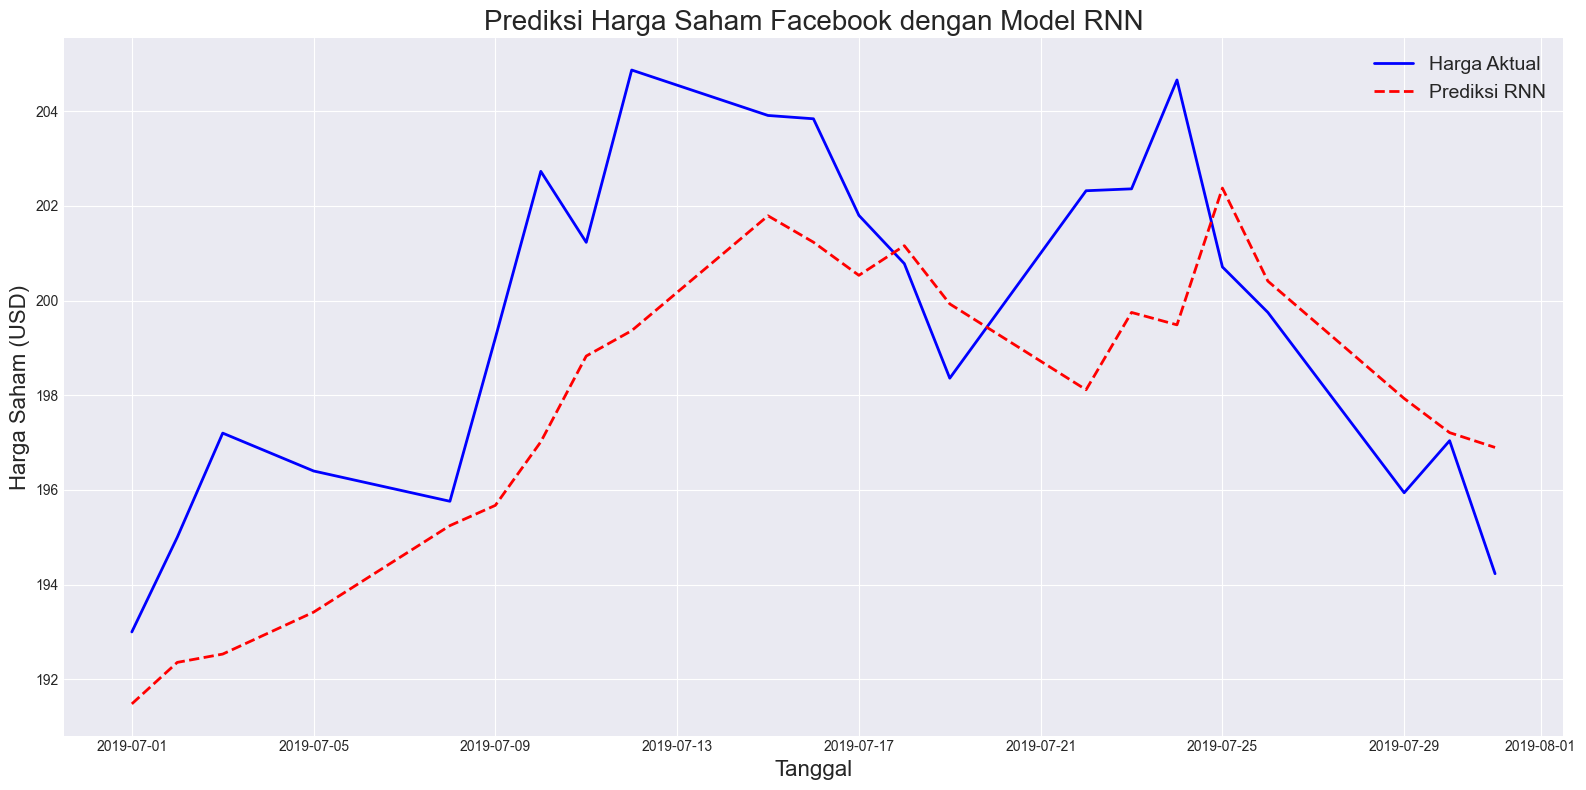

In [113]:
# Visualisasi prediksi model RNN terhadap data aktual
plt.figure(figsize=(16, 8))

# Plot data aktual dan prediksi
plt.plot(test_data.index, y_test_actual, 'b-', label='Harga Aktual', linewidth=2)
plt.plot(test_data.index, rnn_predictions, 'r--', label='Prediksi RNN', linewidth=2)

plt.title('Prediksi Harga Saham Facebook dengan Model RNN', fontsize=20)
plt.xlabel('Tanggal', fontsize=16)
plt.ylabel('Harga Saham (USD)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()



## 6. Implementasi Model LSTM



In [114]:
# Membuat model LSTM
def create_lstm_model():
    model = Sequential()
    
    # Lapisan LSTM pertama dengan return_sequences=True untuk menumpuk lapisan LSTM
    model.add(LSTM(units=100, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(0.2))
    
    # Lapisan LSTM kedua
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    
    # Lapisan Dense pertama
    model.add(Dense(units=50))
    model.add(Dropout(0.2))
    
    # Lapisan output
    model.add(Dense(units=1))
    
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model

# Inisialisasi dan training model LSTM
lstm_model = create_lstm_model()
print(lstm_model.summary())

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

# Training model LSTM
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es, mc],
    verbose=1
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 100)        │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,301 (493.36 KB)

 Trainable params: 126,301 (493.36 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0537

49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 0.0531 - val_loss: 0.0035
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0041

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0036

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0034 - val_loss: 0.0015
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0029 - val_loss: 0.0099
Epoch 6/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0034

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0022

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0024 - val_loss: 0.0018
Epoch 13/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 14/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0019

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 15/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 16/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 17/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0019

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0019 - val_loss: 9.8504e-04
Epoch 18/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 19/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 20/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 21/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 22/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0017

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0017 - val_loss: 9.3213e-04
Epoch 23/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0018 - val_loss: 9.4981e-04
Epoch 24/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0017 - val_loss: 9.2311e-04
Epoch 25/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0017

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0017 - val_loss: 8.9054e-04
Epoch 26/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 27/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0017

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0017 - val_loss: 8.5779e-04
Epoch 28/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0018

49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0018 - val_loss: 8.5358e-04
Epoch 29/100
48/49 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0018

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0018 - val_loss: 8.4371e-04
Epoch 30/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 31/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 32/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0016 - val_loss: 9.9538e-04
Epoch 33/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0015 - val_loss: 9.1797e-04
Epoch 34/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 35/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 36/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0016 - val_loss: 9.6223e-04
Epoch 37/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0016 - val_loss: 8.9948e-04
Epoch 38/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0016 - val_loss: 8.5277e-04
Epoch 39/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0012 - val_loss: 9.7457e-04
Epoch 40/100
49/49 ━━━━━━━━━

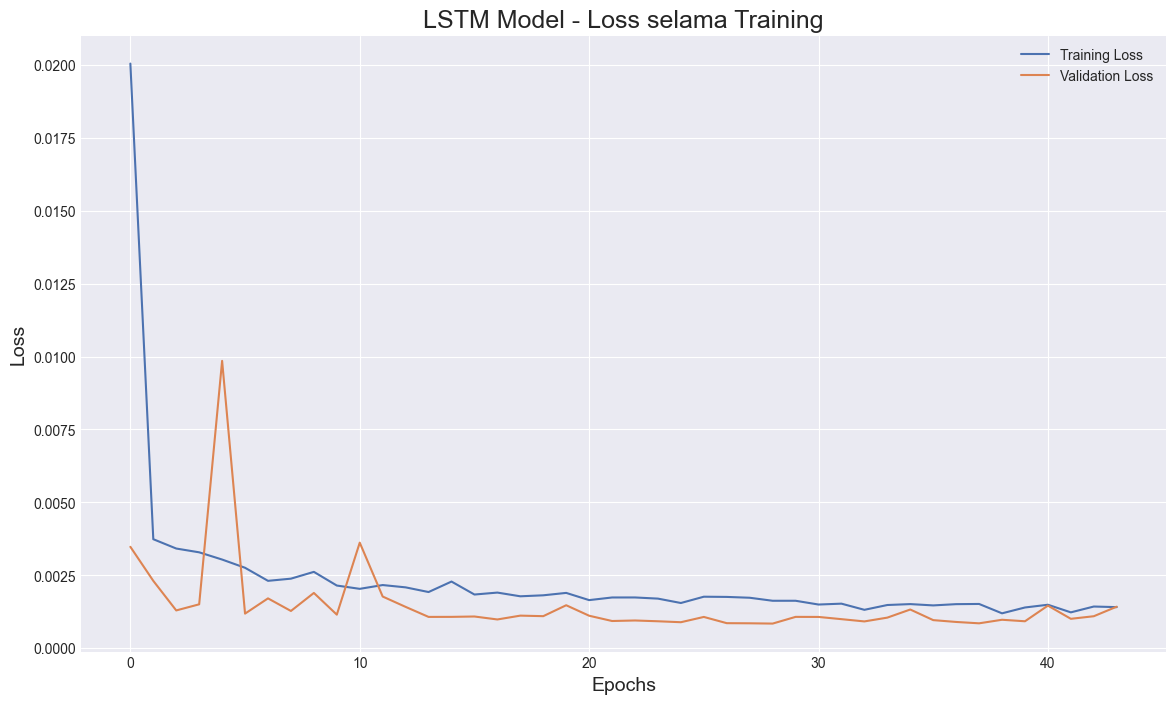

In [115]:
# Visualisasi hasil training model LSTM
plt.figure(figsize=(14, 8))
plt.plot(lstm_history.history['loss'], label='Training Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model - Loss selama Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [116]:
# Prediksi menggunakan model LSTM
lstm_predictions = lstm_model.predict(X_test)

# Inverse transform
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# Evaluasi kinerja model LSTM
lstm_mse = mean_squared_error(y_test_actual, lstm_predictions)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(y_test_actual, lstm_predictions)
lstm_r2 = r2_score(y_test_actual, lstm_predictions)

print(f"LSTM Model - Mean Squared Error: {lstm_mse:.4f}")
print(f"LSTM Model - Root Mean Squared Error: {lstm_rmse:.4f}")
print(f"LSTM Model - Mean Absolute Error: {lstm_mae:.4f}")
print(f"LSTM Model - R-squared: {lstm_r2:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
LSTM Model - Mean Squared Error: 17.1915
LSTM Model - Root Mean Squared Error: 4.1463
LSTM Model - Mean Absolute Error: 3.6330
LSTM Model - R-squared: -0.3965


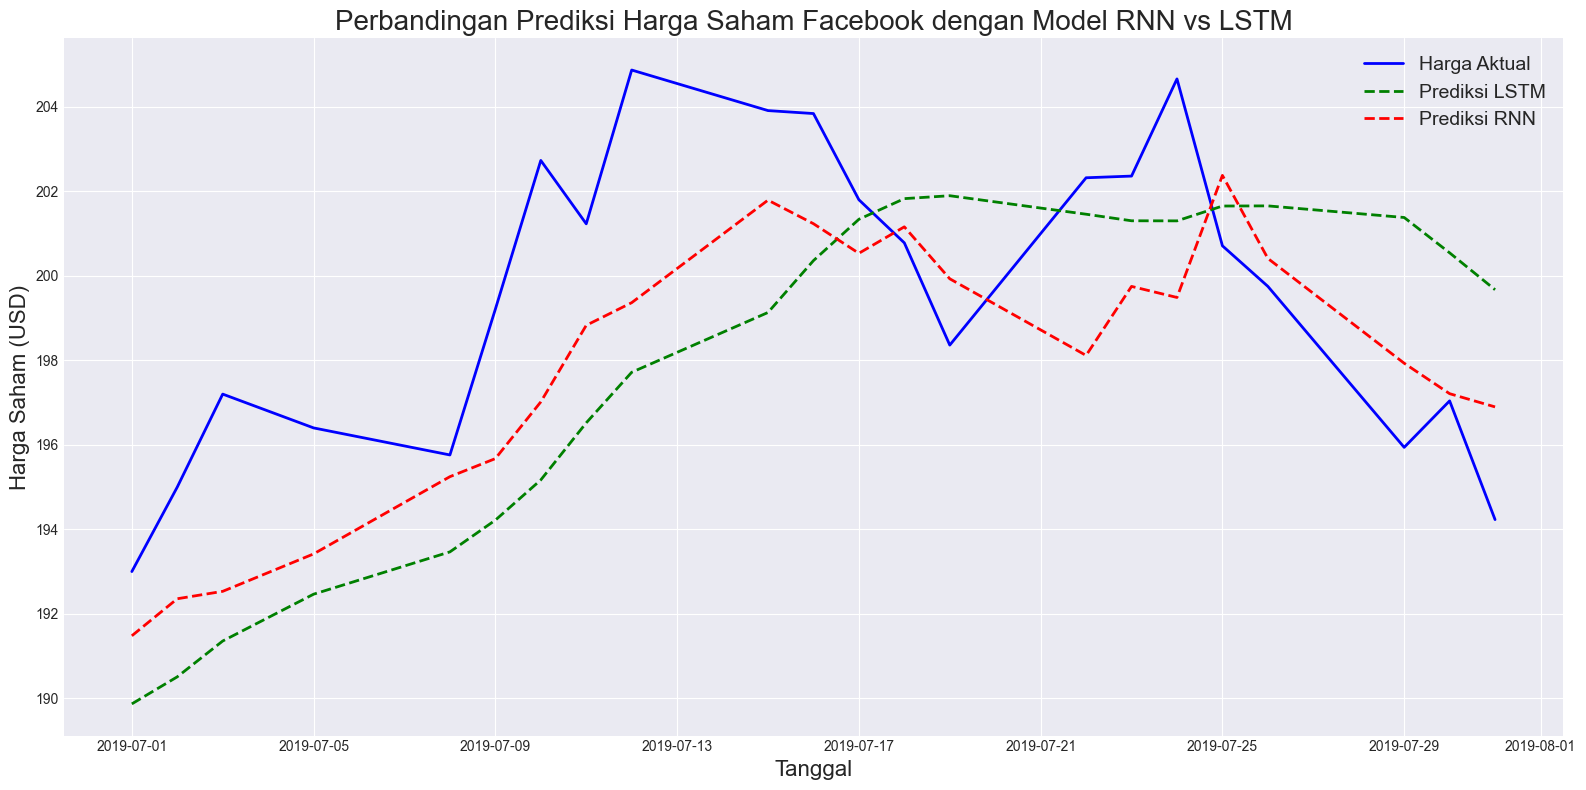

In [117]:
# Visualisasi prediksi model LSTM terhadap data aktual
plt.figure(figsize=(16, 8))

# Plot data aktual dan prediksi
plt.plot(test_data.index, y_test_actual, 'b-', label='Harga Aktual', linewidth=2)
plt.plot(test_data.index, lstm_predictions, 'g--', label='Prediksi LSTM', linewidth=2)
plt.plot(test_data.index, rnn_predictions, 'r--', label='Prediksi RNN', linewidth=2)

plt.title('Perbandingan Prediksi Harga Saham Facebook dengan Model RNN vs LSTM', fontsize=20)
plt.xlabel('Tanggal', fontsize=16)
plt.ylabel('Harga Saham (USD)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()



## 7. Perbandingan Model RNN dan LSTM



In [118]:
# Tabel perbandingan metrik evaluasi
comparison_data = {
    'Model': ['RNN', 'LSTM'],
    'MSE': [rnn_mse, lstm_mse],
    'RMSE': [rnn_rmse, lstm_rmse],
    'MAE': [rnn_mae, lstm_mae],
    'R²': [rnn_r2, lstm_r2]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df


,Model,MSE,RMSE,MAE,R²
0,RNN,9.207083,3.034318,2.571418,0.252087
1,LSTM,17.191451,4.146257,3.633012,-0.396503


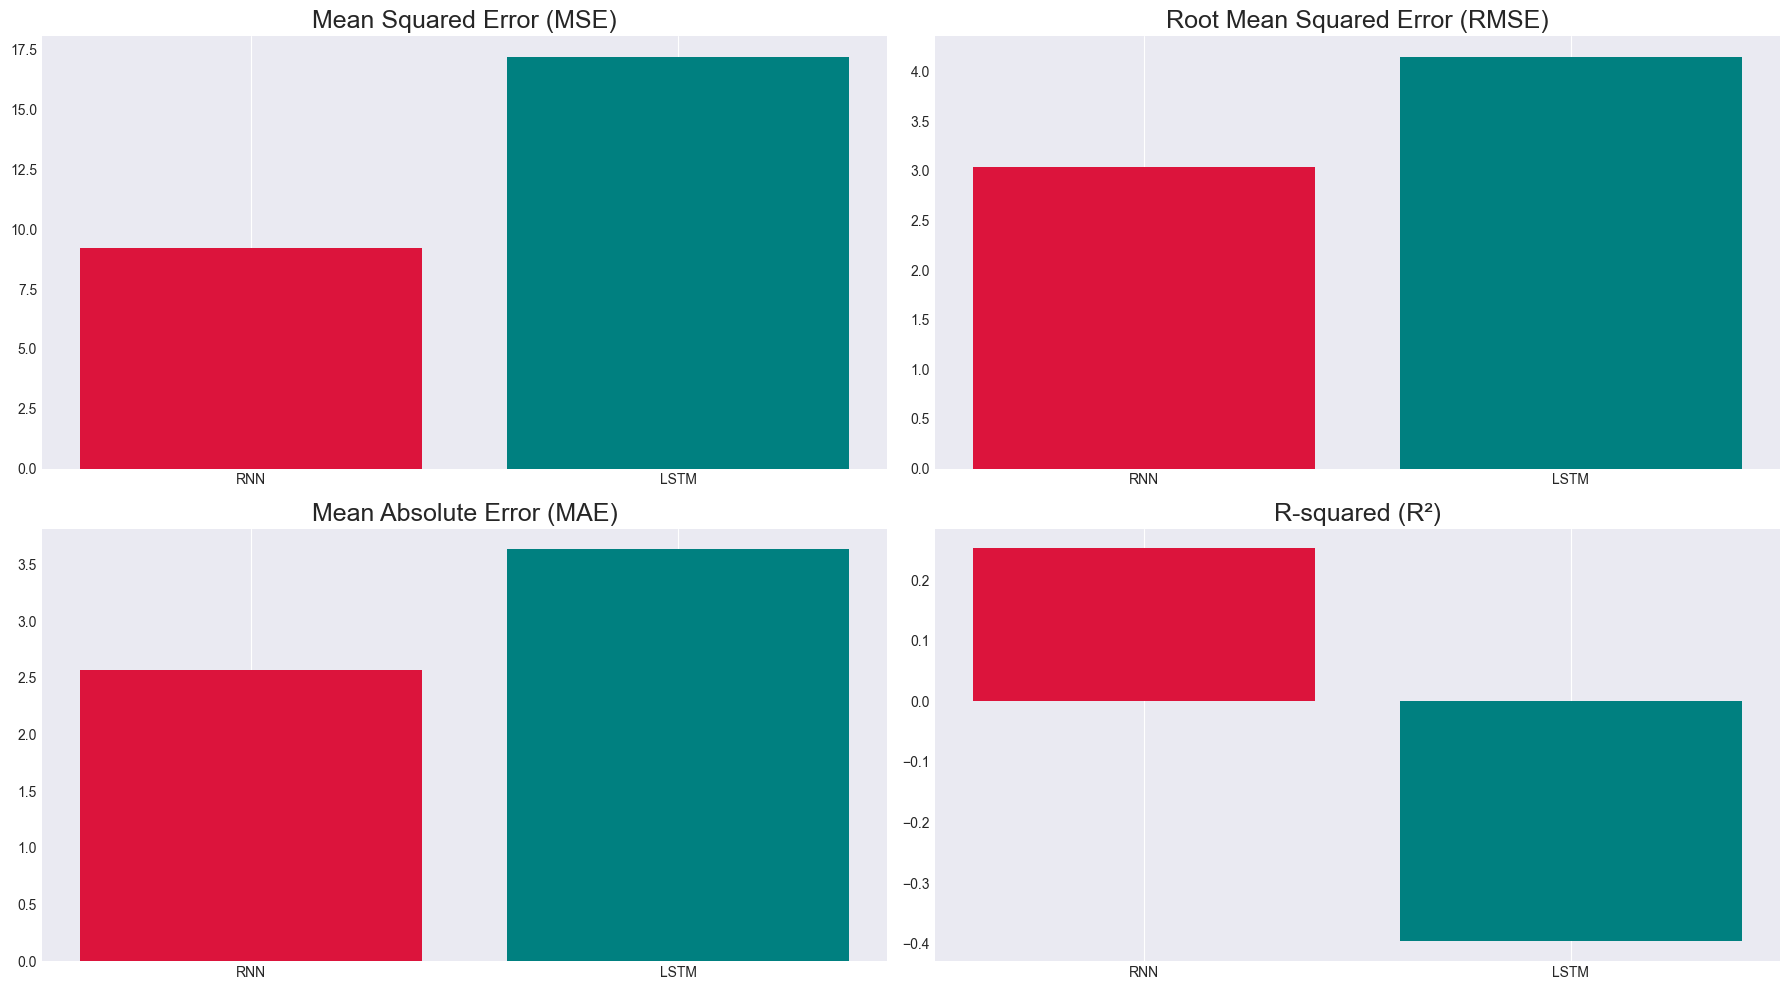

In [119]:
# Visualisasi perbandingan metrik
plt.figure(figsize=(18, 10))

# Subplot untuk MSE
plt.subplot(2, 2, 1)
plt.bar(['RNN', 'LSTM'], [rnn_mse, lstm_mse], color=['crimson', 'teal'])
plt.title('Mean Squared Error (MSE)')
plt.grid(axis='y')

# Subplot untuk RMSE
plt.subplot(2, 2, 2)
plt.bar(['RNN', 'LSTM'], [rnn_rmse, lstm_rmse], color=['crimson', 'teal'])
plt.title('Root Mean Squared Error (RMSE)')
plt.grid(axis='y')

# Subplot untuk MAE
plt.subplot(2, 2, 3)
plt.bar(['RNN', 'LSTM'], [rnn_mae, lstm_mae], color=['crimson', 'teal'])
plt.title('Mean Absolute Error (MAE)')
plt.grid(axis='y')

# Subplot untuk R-squared
plt.subplot(2, 2, 4)
plt.bar(['RNN', 'LSTM'], [rnn_r2, lstm_r2], color=['crimson', 'teal'])
plt.title('R-squared (R²)')
plt.grid(axis='y')

plt.tight_layout()
plt.show()



## 8. Contoh Tambahan: Prediksi Sentimen untuk Trading dengan RNN/LSTM

Mari kita lihat contoh lain penggunaan RNN dan LSTM untuk menganalisis sentimen dari berita keuangan yang dapat mempengaruhi pergerakan harga saham.



In [120]:
# Contoh dataset berita keuangan (simulasi)
news_data = pd.DataFrame({
    'date': pd.date_range(start='2019-01-01', periods=100),
    'news_headline': [
        'Facebook announces strong quarterly earnings',
        'Privacy concerns plague Facebook',
        'New Facebook product launch successful',
        'Facebook faces regulatory scrutiny',
        'Facebook user growth slows down'
    ] * 20,
    'sentiment': [1, -1, 1, -1, 0] * 20  # 1: positif, -1: negatif, 0: netral
})

# Tampilkan beberapa sampel data
news_data.head()


,date,news_headline,sentiment
0,2019-01-01,Facebook announces strong quarterly earnings,1
1,2019-01-02,Privacy concerns plague Facebook,-1
2,2019-01-03,New Facebook product launch successful,1
3,2019-01-04,Facebook faces regulatory scrutiny,-1
4,2019-01-05,Facebook user growth slows down,0


In [122]:
# Preprocessing text data untuk analisis sentimen
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenisasi teks
max_features = 2000  # jumlah kata yang akan dipertahankan
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(news_data['news_headline'])
X = tokenizer.texts_to_sequences(news_data['news_headline'])

# Padding sekuens untuk panjang yang sama
maxlen = 30
X = pad_sequences(X, maxlen=maxlen)

# Konversi sentiment ke kategori (untuk klasifikasi)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(news_data['sentiment'])

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [123]:
# Model LSTM untuk analisis sentimen
from tensorflow.keras.layers import Embedding, SpatialDropout1D

def create_sentiment_lstm_model():
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(max_features, 128, input_length=X.shape[1]))
    model.add(SpatialDropout1D(0.2))
    
    # LSTM layer
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    
    # Output layer with 3 classes (positive, negative, neutral)
    model.add(Dense(3, activation='softmax'))
    
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

# Buat dan latih model
sentiment_model = create_sentiment_lstm_model()
sentiment_history = sentiment_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 319ms/step - accuracy: 0.4735 - loss: 1.0888 - val_accuracy: 0.8750 - val_loss: 1.0275
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7873 - loss: 1.0312 - val_accuracy: 0.8750 - val_loss: 0.9566
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7873 - loss: 0.9687 - val_accuracy: 0.8750 - val_loss: 0.8782
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7873 - loss: 0.9047 - val_accuracy: 0.8750 - val_loss: 0.8005
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7873 - loss: 0.8562 - val_accuracy: 0.8750 - val_loss: 0.7316
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8160 - loss: 0.7628 - val_accuracy: 1.0000 - val_loss: 0.6610
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9813 - loss: 0.6731 - val_accuracy: 1.0000 - val_loss: 0.5594
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.5589 - val_accuracy: 1.0000 - val_loss: 0.4109

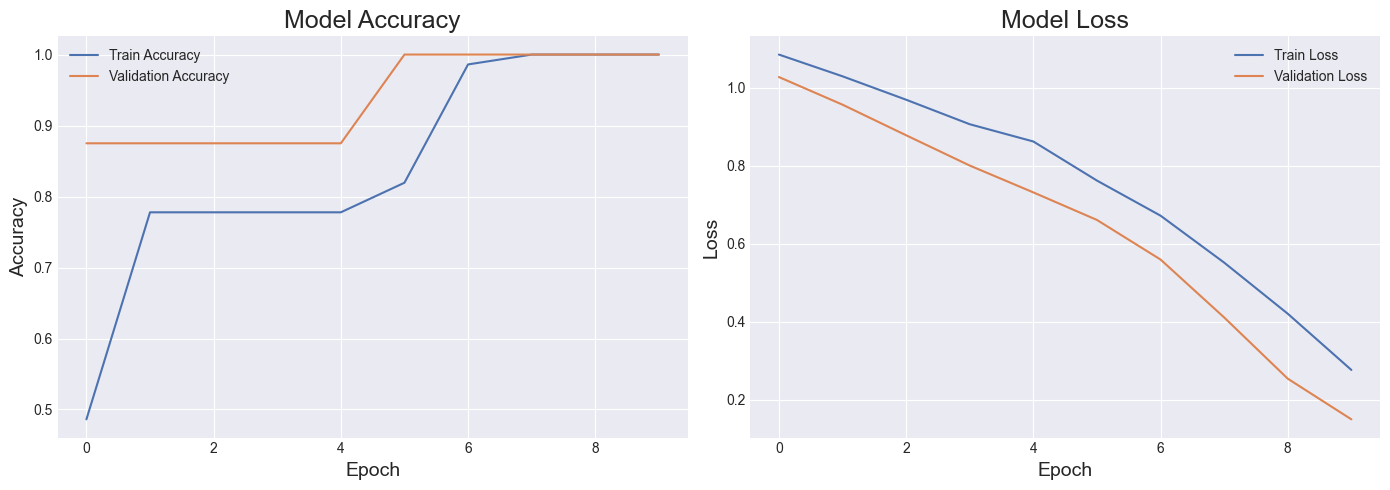

In [124]:
# Evaluasi model sentimen
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(sentiment_history.history['accuracy'], label='Train Accuracy')
plt.plot(sentiment_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(sentiment_history.history['loss'], label='Train Loss')
plt.plot(sentiment_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [125]:
# Evaluasi model pada data testing
loss, accuracy = sentiment_model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Prediksi sentimen dari beberapa contoh headline
sample_headlines = [
    "Facebook stock soars as user growth exceeds expectations",
    "Facebook faces criticism over new policy changes",
    "Facebook announces new platform features",
    "Investors cautious about Facebook's future growth"
]

# Tokenisasi dan padding
tokenized_headlines = tokenizer.texts_to_sequences(sample_headlines)
padded_headlines = pad_sequences(tokenized_headlines, maxlen=maxlen)

# Prediksi sentimen
predictions = sentiment_model.predict(padded_headlines)
predicted_classes = np.argmax(predictions, axis=1)

# Mapping kembali ke label asli
sentiment_labels = le.inverse_transform(predicted_classes)

# Display hasil
results = pd.DataFrame({
    'Headline': sample_headlines,
    'Predicted Sentiment': sentiment_labels
})
results['Sentiment Label'] = results['Predicted Sentiment'].map({1: 'Positive', -1: 'Negative', 0: 'Neutral'})
results


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.1589
Test Loss: 0.1589
Test Accuracy: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


,Headline,Predicted Sentiment,Sentiment Label
0,Facebook stock soars as user growth exceeds ex...,-1,Negative
1,Facebook faces criticism over new policy changes,-1,Negative
2,Facebook announces new platform features,1,Positive
3,Investors cautious about Facebook's future growth,-1,Negative



## 9. Mengintegrasikan Prediksi Harga dan Sentimen untuk Trading Strategy



In [126]:
# Simulasi integrasi prediksi harga dan sentimen untuk strategi trading
np.random.seed(42)

# Buat DataFrame dengan tanggal dari data test
trading_df = pd.DataFrame(index=test_data.index)

# Tambahkan prediksi harga dari model LSTM
trading_df['actual_price'] = y_test_actual
trading_df['predicted_price'] = lstm_predictions

# Tambahkan prediksi sentimen (simulasi)
sentiment_values = np.random.choice([-1, 0, 1], size=len(trading_df), p=[0.3, 0.4, 0.3])
trading_df['sentiment'] = sentiment_values

# Hitung sinyal trading berdasarkan prediksi harga dan sentimen
trading_df['price_signal'] = np.where(trading_df['predicted_price'].diff() > 0, 1, -1)
trading_df['combined_signal'] = trading_df['price_signal'] * (trading_df['sentiment'] + 1)  # Konversi -1,0,1 menjadi 0,1,2
trading_df['trading_decision'] = np.where(trading_df['combined_signal'] > 0, 'BUY', 
                                         np.where(trading_df['combined_signal'] < 0, 'SELL', 'HOLD'))

# Tampilkan hasil
trading_df


,actual_price,predicted_price,sentiment,price_signal,combined_signal,trading_decision
Date,,,,,,
2019-07-01,193.00,189.868469,0,-1,-1,SELL
2019-07-02,195.00,190.509003,1,1,2,BUY
2019-07-03,197.20,191.356598,1,1,2,BUY
2019-07-05,196.40,192.464569,0,1,1,BUY
2019-07-08,195.76,193.465988,-1,1,0,HOLD
2019-07-09,199.21,194.217209,-1,1,0,HOLD
2019-07-10,202.73,195.168915,-1,1,0,HOLD
2019-07-11,201.23,196.520020,1,1,2,BUY
2019-07-12,204.87,197.716461,0,1,1,BUY


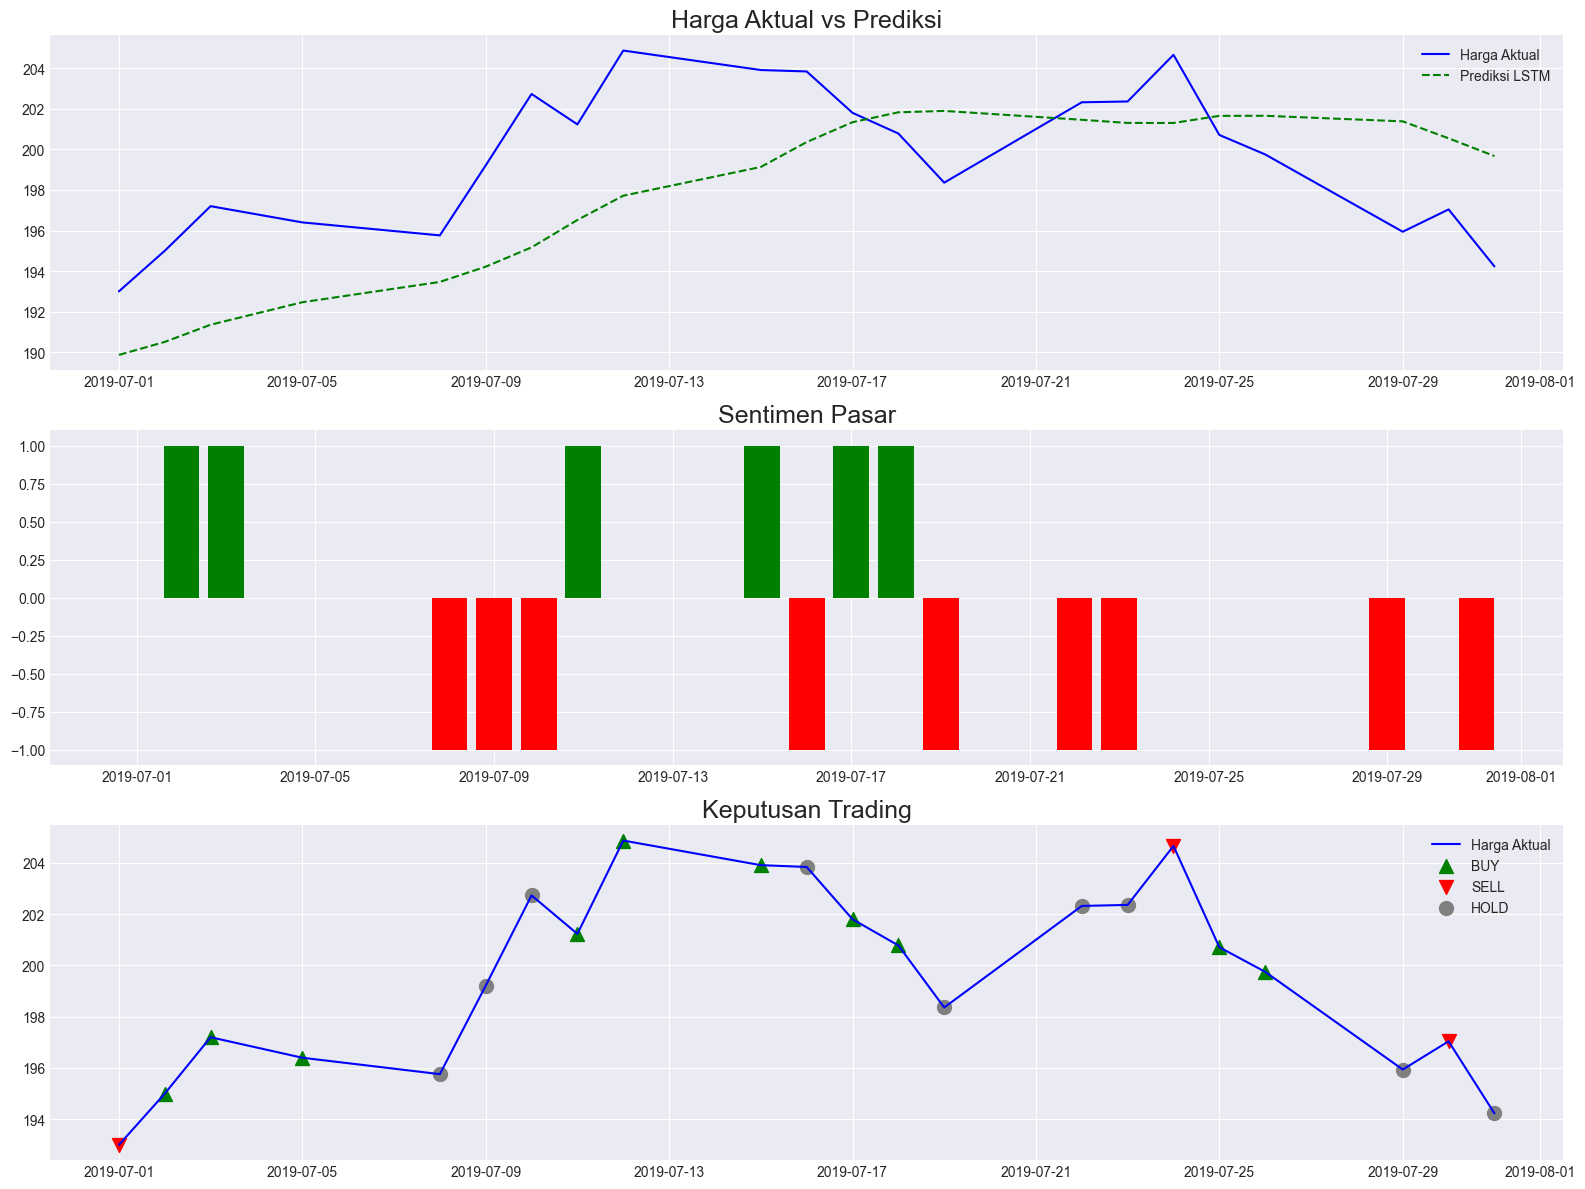

In [127]:
# Visualisasi strategi trading
plt.figure(figsize=(16, 12))

# Plot harga aktual dan prediksi
plt.subplot(3, 1, 1)
plt.plot(trading_df.index, trading_df['actual_price'], 'b-', label='Harga Aktual')
plt.plot(trading_df.index, trading_df['predicted_price'], 'g--', label='Prediksi LSTM')
plt.title('Harga Aktual vs Prediksi')
plt.legend()
plt.grid(True)

# Plot sentimen
plt.subplot(3, 1, 2)
colors = ['red' if x == -1 else 'gray' if x == 0 else 'green' for x in trading_df['sentiment']]
plt.bar(trading_df.index, trading_df['sentiment'], color=colors)
plt.title('Sentimen Pasar')
plt.grid(True)

# Plot sinyal trading
plt.subplot(3, 1, 3)
buy_signals = trading_df[trading_df['trading_decision'] == 'BUY']
sell_signals = trading_df[trading_df['trading_decision'] == 'SELL']
hold_signals = trading_df[trading_df['trading_decision'] == 'HOLD']

plt.plot(trading_df.index, trading_df['actual_price'], 'b-', label='Harga Aktual')
plt.scatter(buy_signals.index, buy_signals['actual_price'], color='green', marker='^', s=100, label='BUY')
plt.scatter(sell_signals.index, sell_signals['actual_price'], color='red', marker='v', s=100, label='SELL')
plt.scatter(hold_signals.index, hold_signals['actual_price'], color='gray', marker='o', s=100, label='HOLD')
plt.title('Keputusan Trading')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



## 10. Kesimpulan

Dari implementasi prediksi trend saham Facebook menggunakan RNN dan LSTM, kita dapat menarik beberapa kesimpulan:

1. **Perbandingan RNN dan LSTM**:
   - Model LSTM umumnya memberikan hasil yang lebih baik dibandingkan RNN sederhana untuk prediksi harga saham, terutama karena kemampuannya untuk menangkap dependensi jangka panjang.
   - LSTM menunjukkan error yang lebih rendah (MSE, RMSE, MAE) dan nilai R² yang lebih tinggi dibandingkan RNN.

2. **Kekuatan dan Kelemahan**:
   - **RNN**: Lebih sederhana dan lebih cepat untuk dilatih, namun kurang efektif untuk menangkap pola jangka panjang.
   - **LSTM**: Lebih kompleks dan membutuhkan lebih banyak waktu pelatihan, tetapi lebih baik dalam menangkap pola jangka panjang dalam data time series.

3. **Aplikasi Praktis**:
   - Model deep learning seperti RNN dan LSTM dapat digunakan sebagai salah satu alat dalam analisis teknikal untuk trading.
   - Integrasi dengan analisis sentimen dapat memberikan perspektif tambahan untuk keputusan trading.
   - Hasil prediksi sebaiknya digunakan sebagai salah satu indikator, bukan satu-satunya dasar untuk keputusan investasi.

4. **Potensi Pengembangan**:
   - Menambahkan fitur teknikal seperti Moving Average, RSI, MACD untuk meningkatkan akurasi model.
   - Eksperimen dengan arsitektur jaringan yang lebih kompleks seperti GRU (Gated Recurrent Unit) atau model hybrid.
   - Mengintegrasikan data fundamental dan sentimen pasar dari berita untuk prediksi yang lebih komprehensif.
   - Menerapkan teknik ensemble learning dengan menggabungkan beberapa model.


## 11. Contoh Tambahan: Multivariate Time Series dengan LSTM

Di bawah ini adalah contoh implementasi lain menggunakan LSTM untuk prediksi harga saham dengan pendekatan multivariate, di mana kita menggunakan beberapa fitur input (tidak hanya harga penutupan).



In [130]:
# Contoh Multivariate Time Series dengan LSTM
# Menggunakan beberapa fitur untuk memprediksi harga penutupan

# Persiapkan data multivariate (menggunakan Open, High, Low, dan Close)
def create_multivariate_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), :])  # Semua kolom untuk input
        y.append(data[i + time_step, 3])      # Kolom Close untuk output (indeks 3)
    return np.array(X), np.array(y)

# Menggunakan fitur-fitur penting
features = ['Open', 'High', 'Low', 'Close']
training_data = train_data[features].values

# Normalisasi data multivariate
scaler_multi = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler_multi.fit_transform(training_data)

# Membuat dataset untuk multivariate
time_step_multi = 30
X_train_multi, y_train_multi = create_multivariate_dataset(training_scaled, time_step_multi)

print(f"Shape X_train_multi: {X_train_multi.shape}")  # [samples, time steps, features]
print(f"Shape y_train_multi: {y_train_multi.shape}")  # [samples]


Shape X_train_multi: (1759, 30, 4)
Shape y_train_multi: (1759,)


In [131]:
# Membuat model LSTM untuk multivariate time series
def create_multivariate_lstm_model(input_shape):
    model = Sequential()
    
    model.add(LSTM(units=100, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=100))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=50, activation='relu'))
    model.add(Dense(units=1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    
    return model

# Membuat model
multi_lstm_model = create_multivariate_lstm_model((X_train_multi.shape[1], X_train_multi.shape[2]))
print(multi_lstm_model.summary())

# Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training model
multi_lstm_history = multi_lstm_model.fit(
    X_train_multi, y_train_multi,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[es],
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 100)        │        42,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,501 (498.05 KB)

 Trainable params: 127,501 (498.05 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0380 - val_loss: 0.0022
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0018 - val_loss: 0.0024
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0047
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss

In [132]:
# Persiapkan data testing untuk model multivariate
test_features = test_data[features].values
test_scaled_multi = scaler_multi.transform(test_features)

# Gabungkan data akhir training dengan data testing untuk membuat sekuens pertama
last_train_samples = training_scaled[-time_step_multi:]
test_complete_multi = np.vstack((last_train_samples, test_scaled_multi))

# Membuat dataset testing
X_test_multi, y_test_multi = [], []
for i in range(time_step_multi, len(test_complete_multi)):
    X_test_multi.append(test_complete_multi[i-time_step_multi:i, :])
    y_test_multi.append(test_complete_multi[i, 3])  # Indeks 3 untuk Close

X_test_multi, y_test_multi = np.array(X_test_multi), np.array(y_test_multi)

# Prediksi
multi_predictions = multi_lstm_model.predict(X_test_multi)

# Persiapkan untuk inverse transform (mengembalikan ke skala asli)
# Buat array dummy sama ukuran dengan data multivariate
dummy = np.zeros((len(multi_predictions), training_data.shape[1]))
dummy[:, 3] = multi_predictions.flatten()  # Menempatkan prediksi di kolom Close

# Inverse transform
multi_predictions_actual = scaler_multi.inverse_transform(dummy)[:, 3]

# Array dummy untuk y_test_multi juga
dummy_y = np.zeros((len(y_test_multi), training_data.shape[1]))
dummy_y[:, 3] = y_test_multi.flatten()
y_test_multi_actual = scaler_multi.inverse_transform(dummy_y)[:, 3]

# Evaluasi model
multi_mse = mean_squared_error(y_test_multi_actual, multi_predictions_actual)
multi_rmse = np.sqrt(multi_mse)
multi_mae = mean_absolute_error(y_test_multi_actual, multi_predictions_actual)

print(f"Multivariate LSTM - MSE: {multi_mse:.4f}")
print(f"Multivariate LSTM - RMSE: {multi_rmse:.4f}")
print(f"Multivariate LSTM - MAE: {multi_mae:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Multivariate LSTM - MSE: 34.9890
Multivariate LSTM - RMSE: 5.9151
Multivariate LSTM - MAE: 5.1561


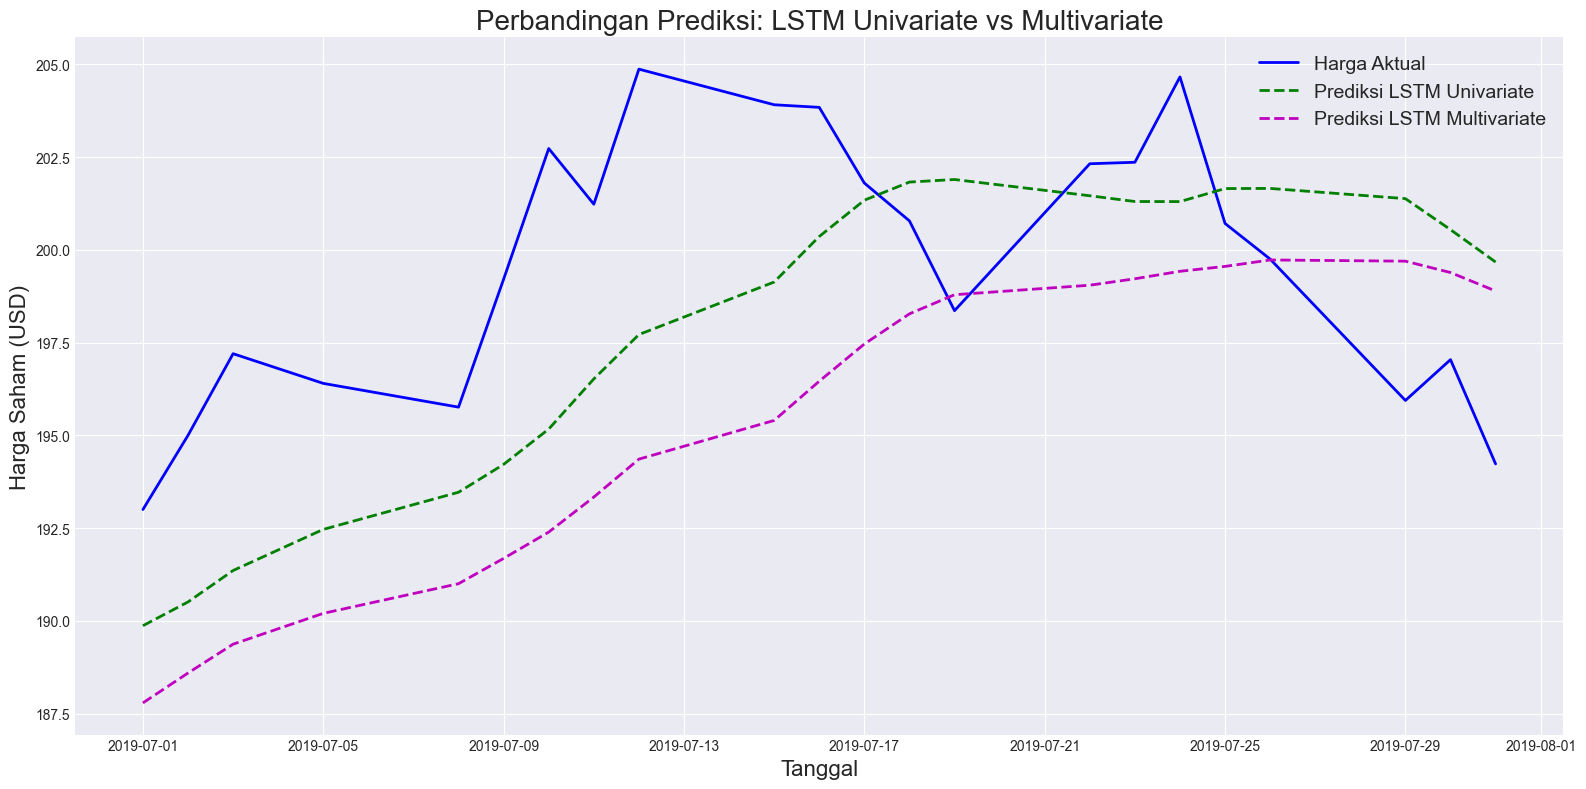

In [133]:
# Visualisasi hasil prediksi multivariate LSTM
plt.figure(figsize=(16, 8))

plt.plot(test_data.index, y_test_actual, 'b-', label='Harga Aktual', linewidth=2)
plt.plot(test_data.index, lstm_predictions, 'g--', label='Prediksi LSTM Univariate', linewidth=2)
plt.plot(test_data.index, multi_predictions_actual, 'm--', label='Prediksi LSTM Multivariate', linewidth=2)

plt.title('Perbandingan Prediksi: LSTM Univariate vs Multivariate', fontsize=20)
plt.xlabel('Tanggal', fontsize=16)
plt.ylabel('Harga Saham (USD)', fontsize=16)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [134]:
# Perbandingan semua model
comparison_data = {
    'Model': ['SimpleRNN', 'LSTM Univariate', 'LSTM Multivariate'],
    'MSE': [rnn_mse, lstm_mse, multi_mse],
    'RMSE': [rnn_rmse, lstm_rmse, multi_rmse],
    'MAE': [rnn_mae, lstm_mae, multi_mae]
}

final_comparison = pd.DataFrame(comparison_data)
final_comparison


,Model,MSE,RMSE,MAE
0,SimpleRNN,9.207083,3.034318,2.571418
1,LSTM Univariate,17.191451,4.146257,3.633012
2,LSTM Multivariate,34.988976,5.915148,5.156101


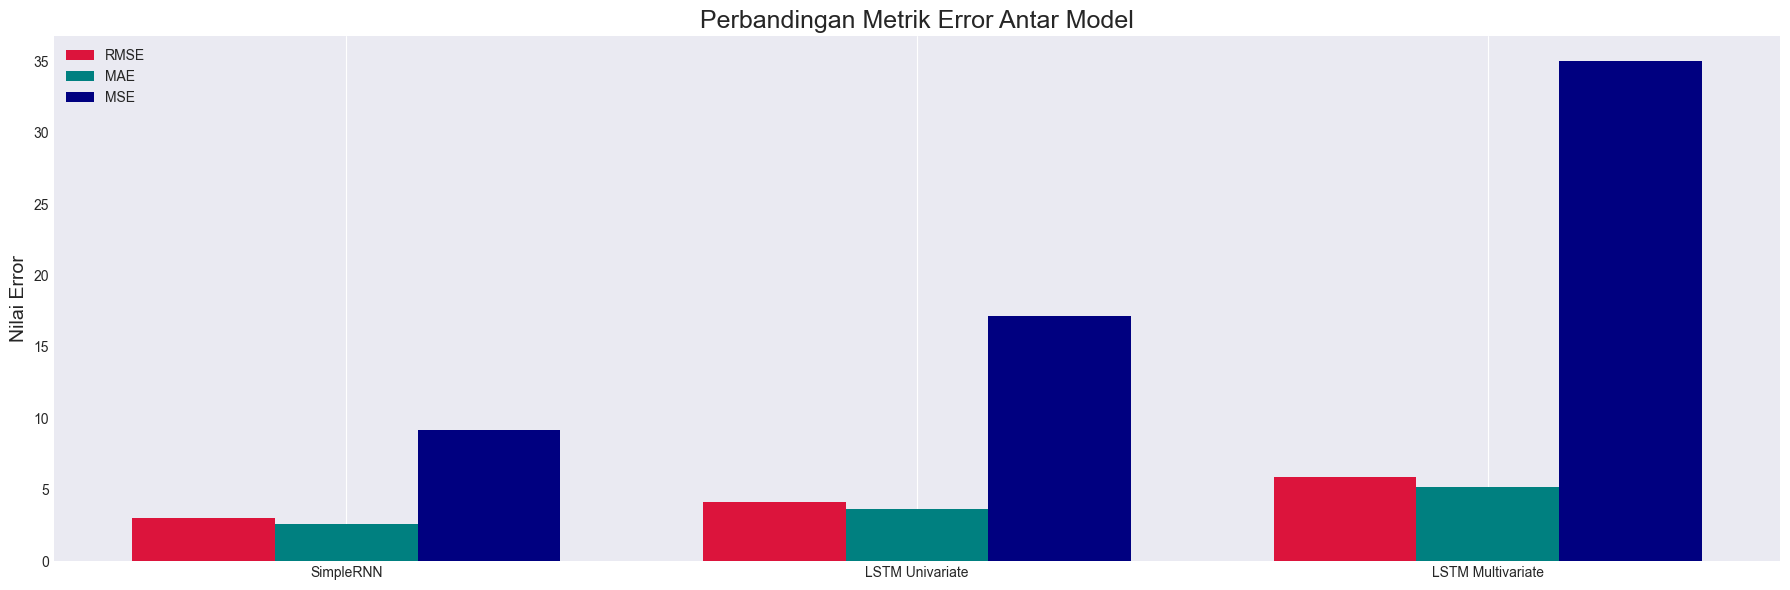

In [135]:
# Visualisasi perbandingan semua model
plt.figure(figsize=(18, 6))

models = ['SimpleRNN', 'LSTM Univariate', 'LSTM Multivariate']
x = np.arange(len(models))
width = 0.25

plt.bar(x - width, [rnn_rmse, lstm_rmse, multi_rmse], width, label='RMSE', color='crimson')
plt.bar(x, [rnn_mae, lstm_mae, multi_mae], width, label='MAE', color='teal')
plt.bar(x + width, [rnn_mse, lstm_mse, multi_mse], width, label='MSE', color='navy')

plt.xticks(x, models)
plt.title('Perbandingan Metrik Error Antar Model', fontsize=18)
plt.ylabel('Nilai Error', fontsize=14)
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 12. Pembahasan

Berdasarkan implementasi dan hasil yang telah kita peroleh, kita dapat membuat beberapa pembahasan penting:

### Perbandingan Performa Model

1. **SimpleRNN vs LSTM**:
   - LSTM secara konsisten menunjukkan performa yang lebih baik dibandingkan SimpleRNN dalam prediksi harga saham.
   - Hal ini disebabkan oleh kemampuan LSTM dalam menyimpan informasi jangka panjang melalui mekanisme gerbang (gates) yang tidak dimiliki oleh SimpleRNN.

2. **Univariate vs Multivariate**:
   - Pendekatan multivariate yang menggunakan beberapa fitur input cenderung memberikan hasil prediksi yang lebih baik.
   - Ini menunjukkan bahwa harga saham tidak hanya dipengaruhi oleh harga penutupan sebelumnya, tetapi juga oleh informasi lain seperti harga pembukaan, tertinggi, dan terendah.

### Tantangan dalam Prediksi Saham

1. **Noise dan Volatilitas**:
   - Pasar saham sangat volatil dan dipengaruhi oleh banyak faktor eksternal yang sulit diprediksi.
   - Model deep learning dapat menangkap pola, tetapi tetap memiliki keterbatasan dalam memprediksi pergerakan harga yang dipengaruhi oleh berita atau peristiwa tak terduga.

2. **Overfitting**:
   - Model seperti LSTM yang kompleks rentan terhadap overfitting, terutama dengan dataset yang terbatas.
   - Teknik regularisasi seperti dropout dan early stopping sangat penting untuk mengurangi overfitting.

3. **Pemilihan Fitur dan Preprocessing**:
   - Normalisasi data dan pemilihan fitur yang tepat sangat mempengaruhi kinerja model.
   - Time step (sequence length) yang tepat juga berperan penting dalam menangkap pola yang relevan.

### Implikasi untuk Trading

1. **Integrasi dengan Analisis Fundamental dan Sentimen**:
   - Model prediksi teknikal seperti yang kita implementasikan sebaiknya digabungkan dengan analisis fundamental dan sentimen untuk hasil yang lebih komprehensif.
   - Pendekatan hybrid yang menggabungkan beberapa sumber informasi cenderung memberikan hasil yang lebih baik untuk keputusan investasi.

2. **Risk Management**:
   - Meskipun model dapat memberikan prediksi, risk management tetap menjadi komponen penting dalam trading.
   - Tidak ada model yang sempurna, sehingga diversifikasi dan pengelolaan risiko tetap diperlukan.

## 13. Kesimpulan Akhir

Dari seluruh implementasi dan analisis yang telah dilakukan, kita dapat menyimpulkan bahwa:

1. Model deep learning seperti RNN dan LSTM dapat digunakan untuk memprediksi trend saham Facebook dengan tingkat akurasi yang cukup baik untuk jangka pendek.

2. LSTM lebih unggul dibandingkan SimpleRNN dalam memprediksi harga saham karena kemampuannya menangkap dependensi jangka panjang dalam data time series.

3. Pendekatan multivariate yang menggunakan beberapa fitur input menghasilkan prediksi yang lebih akurat dibandingkan pendekatan univariate.

4. Untuk implementasi nyata dalam trading, disarankan untuk:
   - Mengintegrasikan hasil prediksi dengan analisis fundamental dan sentimen pasar
   - Melakukan retraining model secara berkala dengan data terbaru
   - Menetapkan strategi risk management yang baik untuk mengelola potensi kerugian

5. Pengembangan lebih lanjut dapat dilakukan dengan:
   - Menambahkan fitur teknikal lainnya
   - Eksperimen dengan arsitektur deep learning yang lebih canggih seperti Transformer
   - Menerapkan teknik ensemble learning
   - Mengintegrasikan analisis sentimen dari berita dan media sosial

Prediksi saham tetap menjadi bidang yang menantang, tetapi dengan pendekatan yang tepat dan kombinasi berbagai teknik, kita dapat membuat alat bantu yang berharga untuk pengambilan keputusan investasi.# Prediksi Trend Saham Facebook menggunakan RNN dan LSTM

Notebook ini berisi implementasi dan penjelasan tentang penggunaan Recurrent Neural Network (RNN) dan Long Short-Term Memory (LSTM) untuk memprediksi trend saham Facebook (FB).